In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [2]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [3]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [4]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [5]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [6]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",
        "#d62728",
        "#ff7f0e",
        "#2ca02c",
    ]

    markers = ["--o", "-s", "-^", "-x"]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(20, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                markers[j],
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=24)
            if i == 0: axes[i].legend(prop={"size": 16}, loc="upper right")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 71, 10)))

    fig.supxlabel("Task Trained On", fontsize=24)
    fig.supylabel("Accuracy (%)\n", fontsize=24)
    plt.tight_layout()
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

Tiny ImageNet 10 Tasks, 20 Classes Per Task

# ER

## Buffer 500

### Without Drift

In [7]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-21-25-17-28-01-seq-tinyimg-er-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-21-25-20-11-49-seq-tinyimg-er-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-21-25-14-39-04-seq-tinyimg-er-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 6.22 ± 0.11
Avg. Forgetting: 57.50 ± 0.11


### With Permutation Drift in Tasks 4, 7

In [8]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-01-43-28-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-22-25-04-26-24-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-21-25-22-58-54-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 6.25 ± 0.15
Avg. Forgetting: 58.50 ± 0.26


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [9]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-08-10-25-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-22-25-15-42-47-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-22-25-11-55-36-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 6.64 ± 0.15
Avg. Forgetting: 55.21 ± 0.34


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [10]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-00-27-53-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-22-25-18-37-57-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-22-25-21-28-51-seq-tinyimg-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 6.19 ± 0.15
Avg. Forgetting: 57.67 ± 0.54


### Cumulative Plots

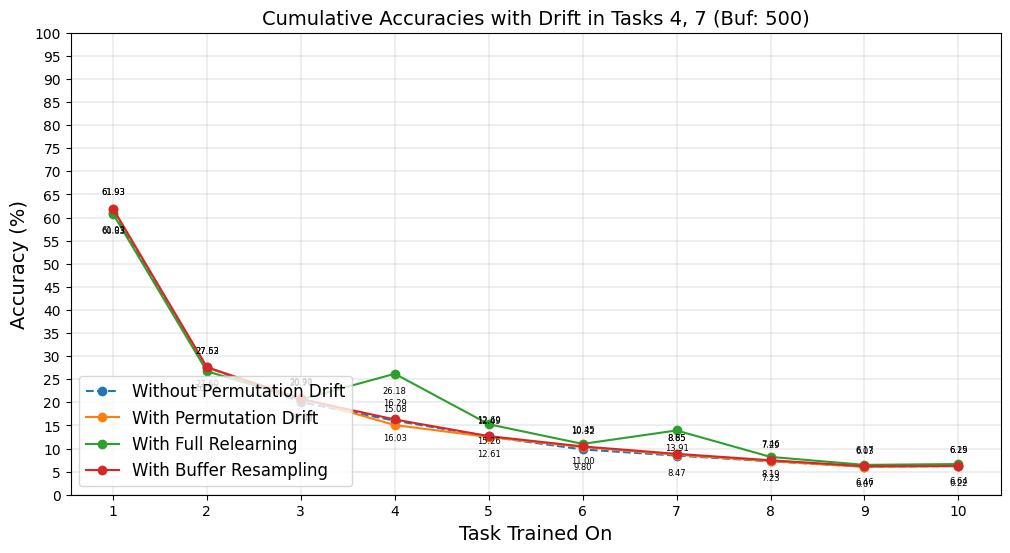

In [11]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [12]:
er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-21-25-17-27-04-seq-tinyimg-er-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-21-25-14-40-46-seq-tinyimg-er-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-21-25-20-10-23-seq-tinyimg-er-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 9.91 ± 0.26
Avg. Forgetting: 58.40 ± 0.15


### With Permutation Drift in Tasks 4, 7

In [13]:
er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-21-25-22-55-03-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-22-25-01-38-38-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-22-25-04-23-06-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 8.30 ± 0.06
Avg. Forgetting: 60.74 ± 0.20


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [14]:
er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-16-46-30-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-22-25-08-30-50-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-22-25-12-38-12-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 9.69 ± 0.05
Avg. Forgetting: 56.20 ± 0.69


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [15]:
er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-19-41-17-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-22-25-22-35-13-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-23-25-01-39-37-seq-tinyimg-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 10.12 ± 0.08
Avg. Forgetting: 57.86 ± 0.52


### Cumulative Plots

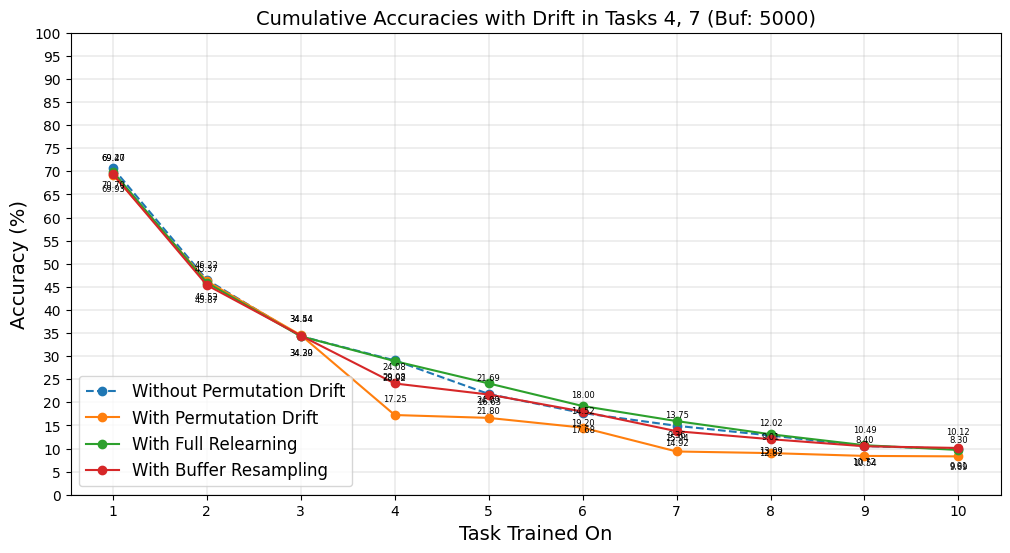

In [16]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Without Drift

In [17]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-21-25-15-36-21-seq-tinyimg-er_ace-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-21-25-19-04-11-seq-tinyimg-er_ace-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-21-25-22-30-33-seq-tinyimg-er_ace-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 10.76 ± 0.13
Avg. Forgetting: 32.76 ± 0.70


### With Permutation Drift in Tasks 4, 7

In [18]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-01-52-31-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-22-25-08-48-15-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-22-25-05-17-38-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 5.00 ± 0.18
Avg. Forgetting: 37.99 ± 0.48


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [19]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-13-27-40-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-22-25-18-10-28-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-22-25-23-22-14-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 6.00 ± 0.37
Avg. Forgetting: 39.87 ± 0.39


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [20]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-11-49-52-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-23-25-03-44-31-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-23-25-07-57-07-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 5.96 ± 0.20
Avg. Forgetting: 38.40 ± 0.23


### Cumulative Plots

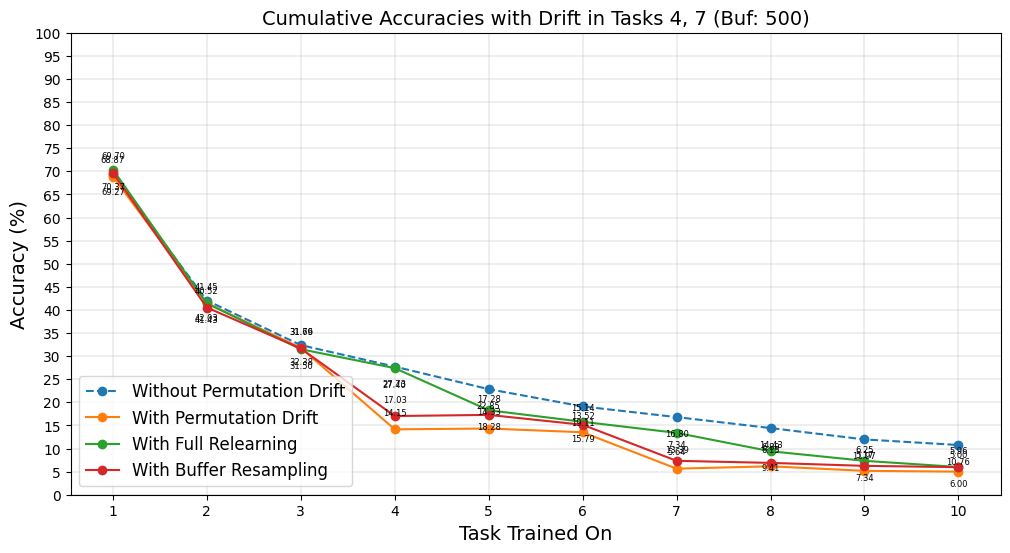

In [21]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [22]:
er_ace_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-21-25-15-21-40-seq-tinyimg-er_ace-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-21-25-18-28-23-seq-tinyimg-er_ace-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-21-25-21-36-02-seq-tinyimg-er_ace-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 16.16 ± 0.30
Avg. Forgetting: 32.52 ± 0.39


### With Permutation Drift in Tasks 4, 7

In [23]:
er_ace_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-06-52-56-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-22-25-00-40-47-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-22-25-03-45-18-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 8.60 ± 0.09
Avg. Forgetting: 40.89 ± 0.24


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [24]:
er_ace_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-21-39-15-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-22-25-16-39-41-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-22-25-11-44-12-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 11.71 ± 0.04
Avg. Forgetting: 38.26 ± 0.54


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [25]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-05-13-54-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-23-25-01-35-48-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-23-25-08-55-01-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 11.10 ± 0.17
Avg. Forgetting: 41.24 ± 0.49


### Cumulative Plots

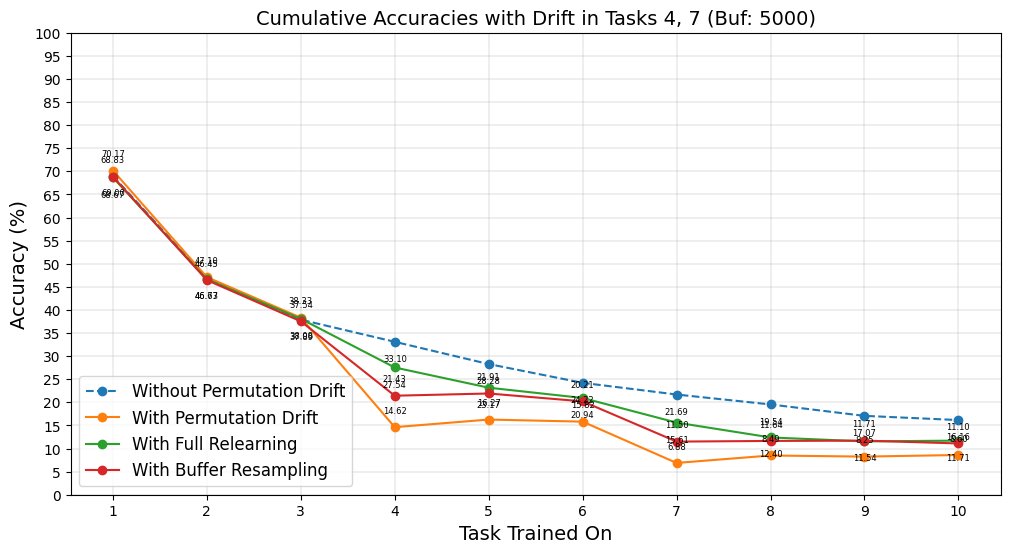

In [26]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# DER++

## Buffer 500

### Without Drift

In [27]:
derpp_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-22-53-42-seq-tinyimg-derpp-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-21-25-23-57-42-seq-tinyimg-derpp-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-22-25-11-25-15-seq-tinyimg-derpp-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 6.61 ± 0.10
Avg. Forgetting: 58.85 ± 0.32


### With Permutation Drift in Tasks 4, 7

In [28]:
derpp_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-10-21-04-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-23-25-21-49-31-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-24-25-09-18-57-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 6.45 ± 0.12
Avg. Forgetting: 58.67 ± 0.28


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [29]:
derpp_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-26-25-08-28-17-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-25-25-01-04-21-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-25-25-16-46-18-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 7.04 ± 0.19
Avg. Forgetting: 48.77 ± 0.23


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [30]:
derpp_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-27-25-19-08-32-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-27-25-07-34-47-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-26-25-20-02-04-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 6.65 ± 0.24
Avg. Forgetting: 56.54 ± 0.57


### Cumulative Plots

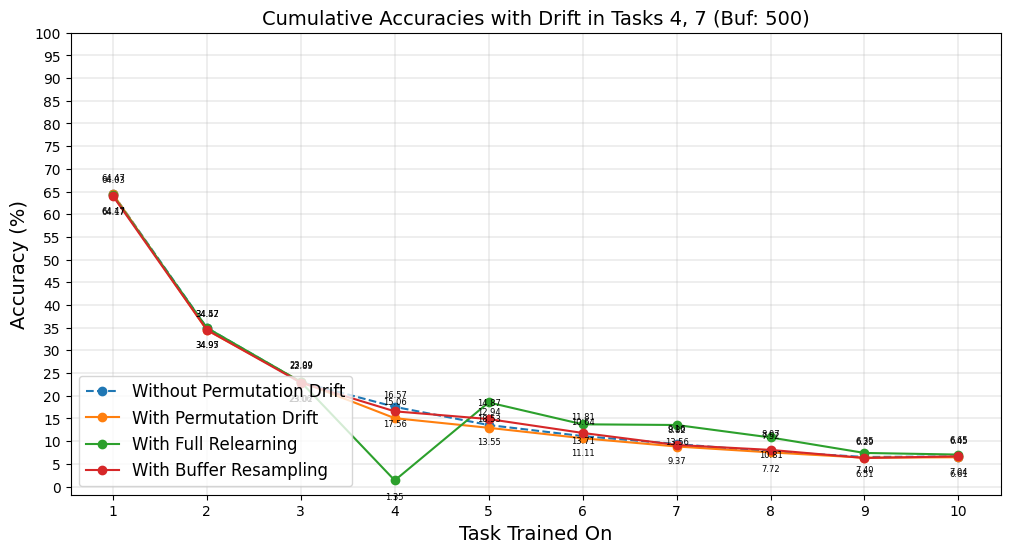

In [31]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [32]:
derpp_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-22-25-00-04-47-seq-tinyimg-derpp-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-22-25-11-40-08-seq-tinyimg-derpp-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-22-25-23-13-42-seq-tinyimg-derpp-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 11.55 ± 0.45
Avg. Forgetting: 36.43 ± 0.22


### With Permutation Drift in Tasks 4, 7

In [33]:
derpp_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-10-49-00-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-24-25-09-58-02-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-23-25-22-23-45-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 6.52 ± 0.08
Avg. Forgetting: 42.46 ± 0.79


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [34]:
derpp_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-25-25-20-43-46-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-25-25-03-21-36-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-26-25-14-04-56-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 10.52 ± 0.30
Avg. Forgetting: 39.23 ± 0.60


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [35]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-27-25-13-26-27-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-27-25-01-46-07-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-28-25-01-08-09-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 9.87 ± 0.62
Avg. Forgetting: 49.14 ± 0.69


### Cumulative Plots

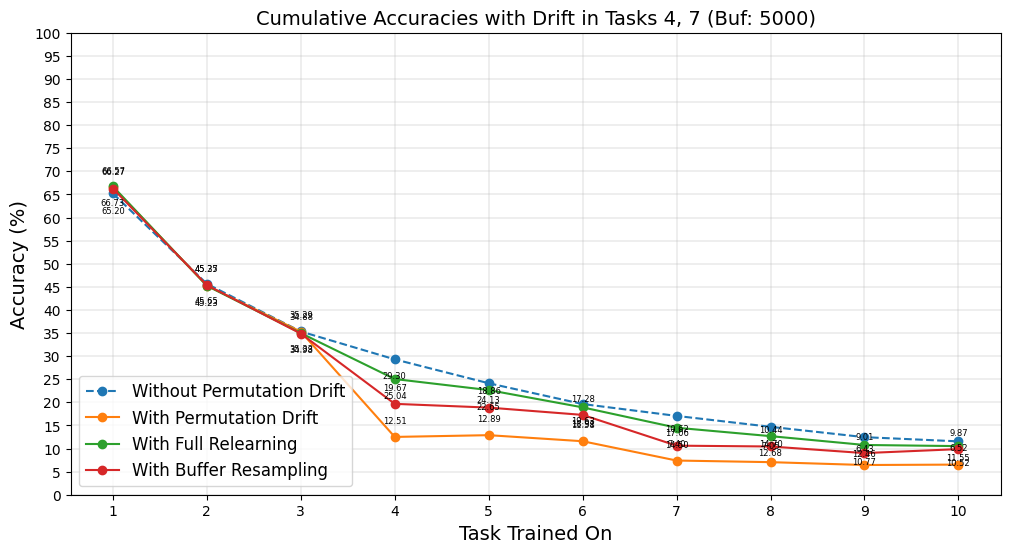

In [36]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# SER

## Buffer 500

### Without Drift

In [37]:
ser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-01-20-53-seq-tinyimg-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/05-01-25-07-26-40-seq-tinyimg-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-30-25-19-19-38-seq-tinyimg-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 16.41 ± 0.59
Avg. Forgetting: 21.69 ± 0.35


### With Permutation Drift in Tasks 4, 7

In [38]:
ser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-19-39-19-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/05-02-25-01-41-21-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/05-01-25-13-32-13-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 10.74 ± 0.26
Avg. Forgetting: 27.80 ± 0.54


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [39]:
ser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-03-25-02-25-48-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/05-02-25-09-59-50-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/05-02-25-18-14-15-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 11.71 ± 0.12
Avg. Forgetting: 26.65 ± 0.74


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [40]:
ser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-03-25-08-33-55-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/05-03-25-14-39-54-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/05-03-25-20-26-37-seq-tinyimg-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 7.32 ± 0.29
Avg. Forgetting: 28.07 ± 0.26


### Cumulative Plots

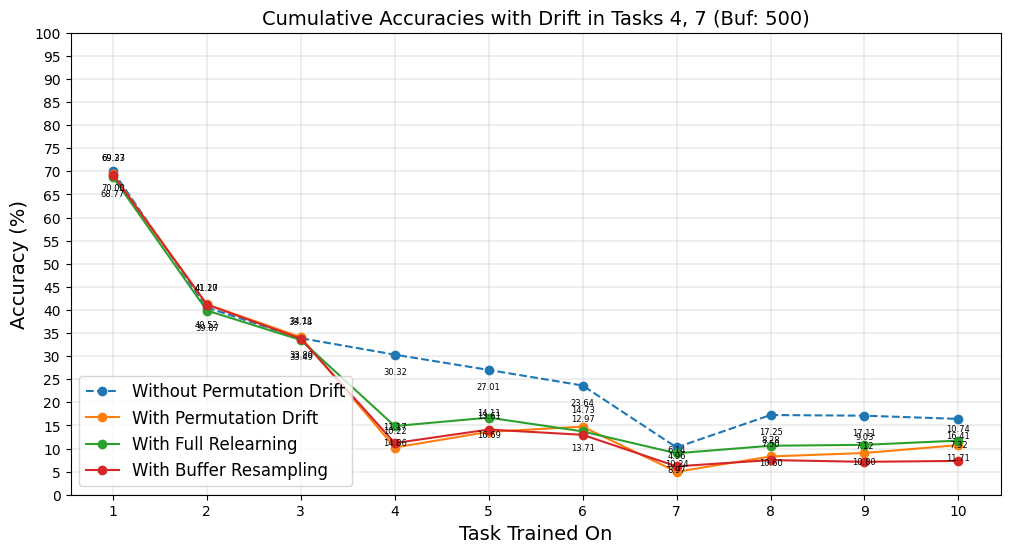

In [41]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [42]:
ser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-30-25-19-17-08-seq-tinyimg-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/05-01-25-07-21-34-seq-tinyimg-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/05-01-25-01-16-28-seq-tinyimg-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 16.22 ± 0.45
Avg. Forgetting: 10.87 ± 0.29


### With Permutation Drift in Tasks 4, 7

In [43]:
ser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-19-29-44-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/05-01-25-13-24-01-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/05-02-25-01-33-54-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 7.33 ± 0.29
Avg. Forgetting: 20.35 ± 0.27


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [44]:
ser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-10-52-22-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/05-03-25-05-25-16-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/05-02-25-20-06-57-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 9.46 ± 0.38
Avg. Forgetting: 20.87 ± 0.52


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [45]:
ser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-03-25-17-32-57-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/05-03-25-23-38-11-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/05-03-25-11-31-05-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 10.53 ± 0.22
Avg. Forgetting: 23.22 ± 0.09


### Cumulative Plots

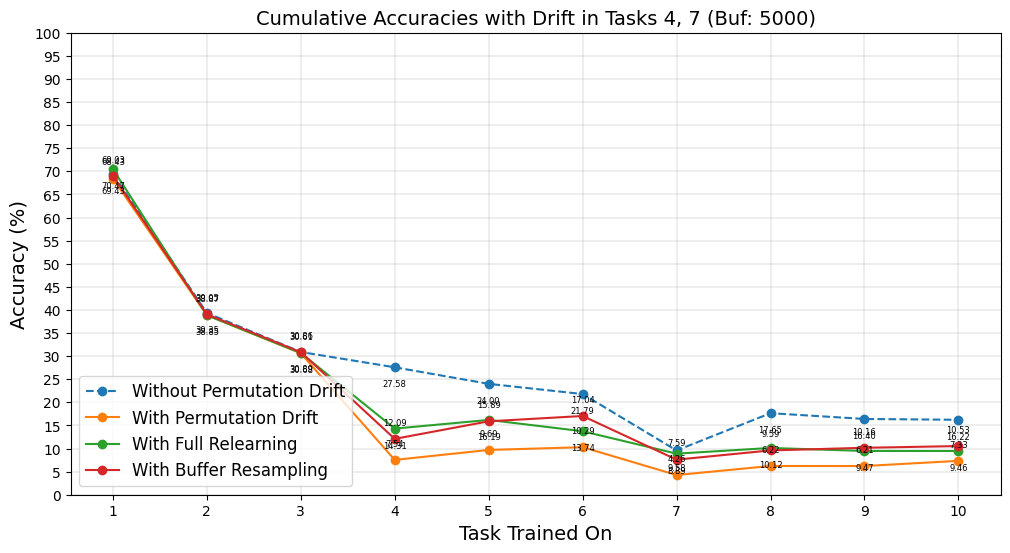

In [46]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# CLSER

## Buffer 500

### Without Drift

In [47]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-30-25-22-12-30-seq-tinyimg-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-30-25-17-47-59-seq-tinyimg-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/05-01-25-02-41-57-seq-tinyimg-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 6.50 ± 0.07
Avg. Forgetting: 57.30 ± 0.11


### With Permutation Drift in Tasks 4, 7

In [48]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-07-09-00-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/05-01-25-11-39-13-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/05-01-25-16-14-35-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 6.30 ± 0.00
Avg. Forgetting: 57.60 ± 0.35


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [49]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-10-32-01-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/05-01-25-22-23-51-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/05-02-25-04-25-28-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 7.87 ± 0.04
Avg. Forgetting: 53.70 ± 0.56


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [50]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-03-25-00-20-45-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/05-02-25-19-43-11-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/05-02-25-15-07-50-seq-tinyimg-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 7.46 ± 0.19
Avg. Forgetting: 56.56 ± 0.46


### Cumulative Plots

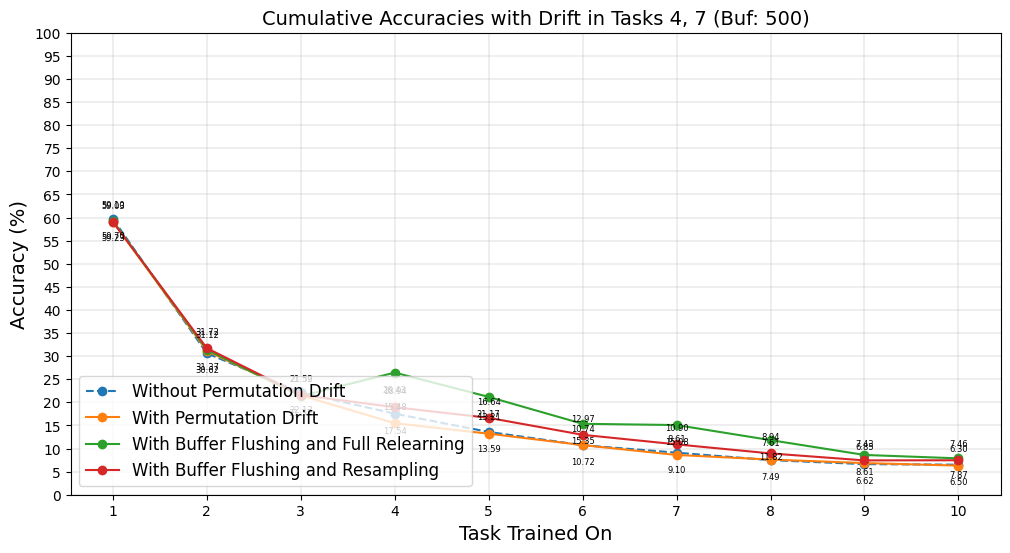

In [51]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [52]:
clser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-30-25-22-14-47-seq-tinyimg-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/05-01-25-03-20-10-seq-tinyimg-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-30-25-17-49-20-seq-tinyimg-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 16.23 ± 0.38
Avg. Forgetting: 39.80 ± 0.49


### With Permutation Drift in Tasks 4, 7

In [53]:
clser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-13-04-17-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/05-01-25-08-00-33-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/05-05-25-19-16-23-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 9.81 ± 0.16
Avg. Forgetting: 46.77 ± 0.45


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [54]:
clser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-17-06-09-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/05-06-25-02-39-20-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/05-06-25-09-58-28-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 14.47 ± 0.18
Avg. Forgetting: 42.63 ± 0.46


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [55]:
clser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-07-25-06-25-28-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/05-06-25-03-56-12-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/05-06-25-17-09-09-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 14.33 ± 0.29
Avg. Forgetting: 43.24 ± 1.02


### Cumulative Plots

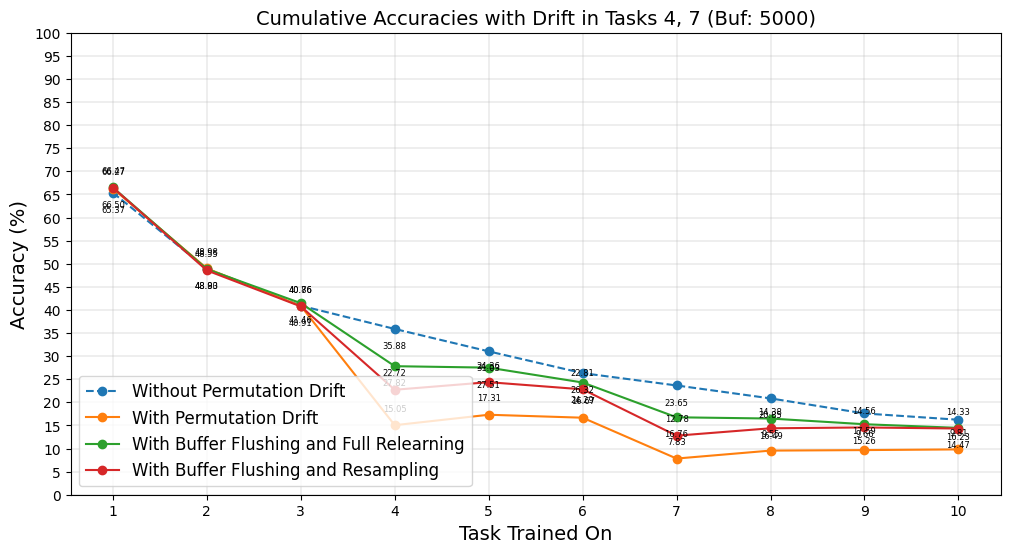

In [56]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

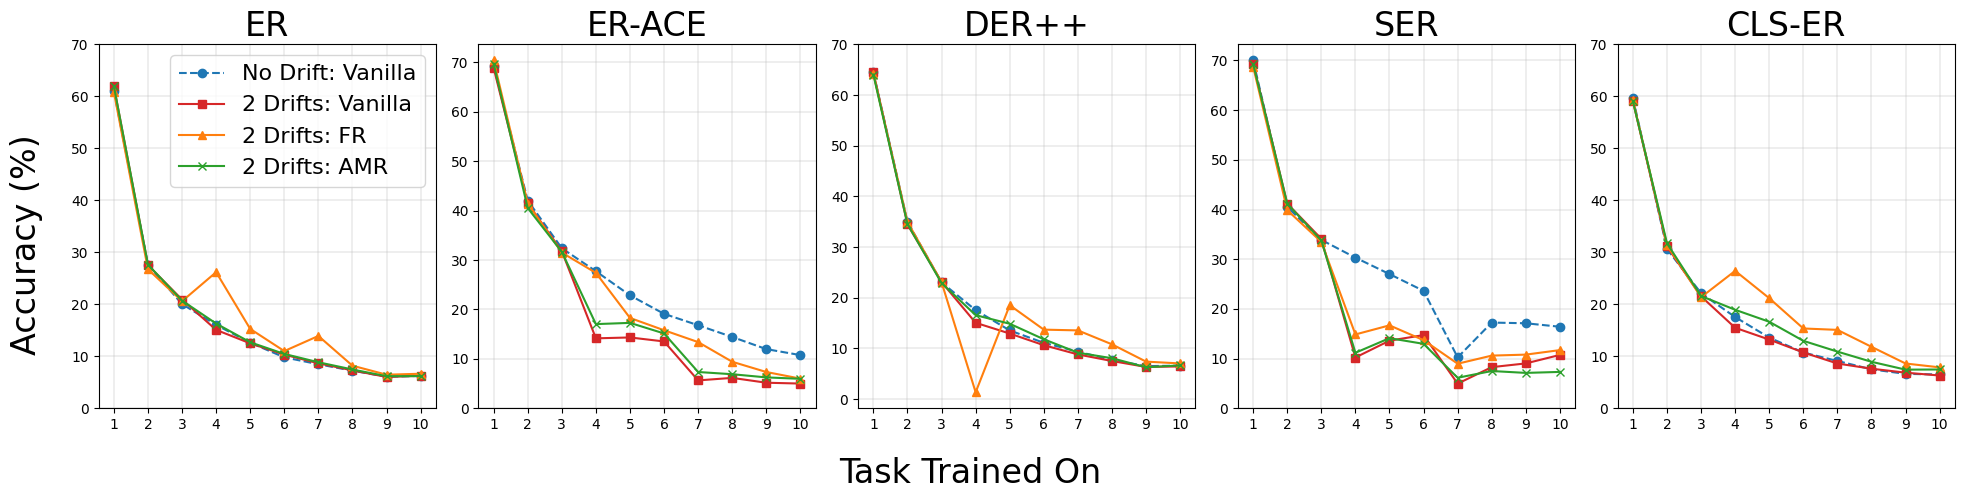

In [ ]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: FR",
        "2 Drifts: AMR",
    ],
    # plot_filename="TinyImg_Buff_500_n_2.pdf",
)

## Buffer 5000

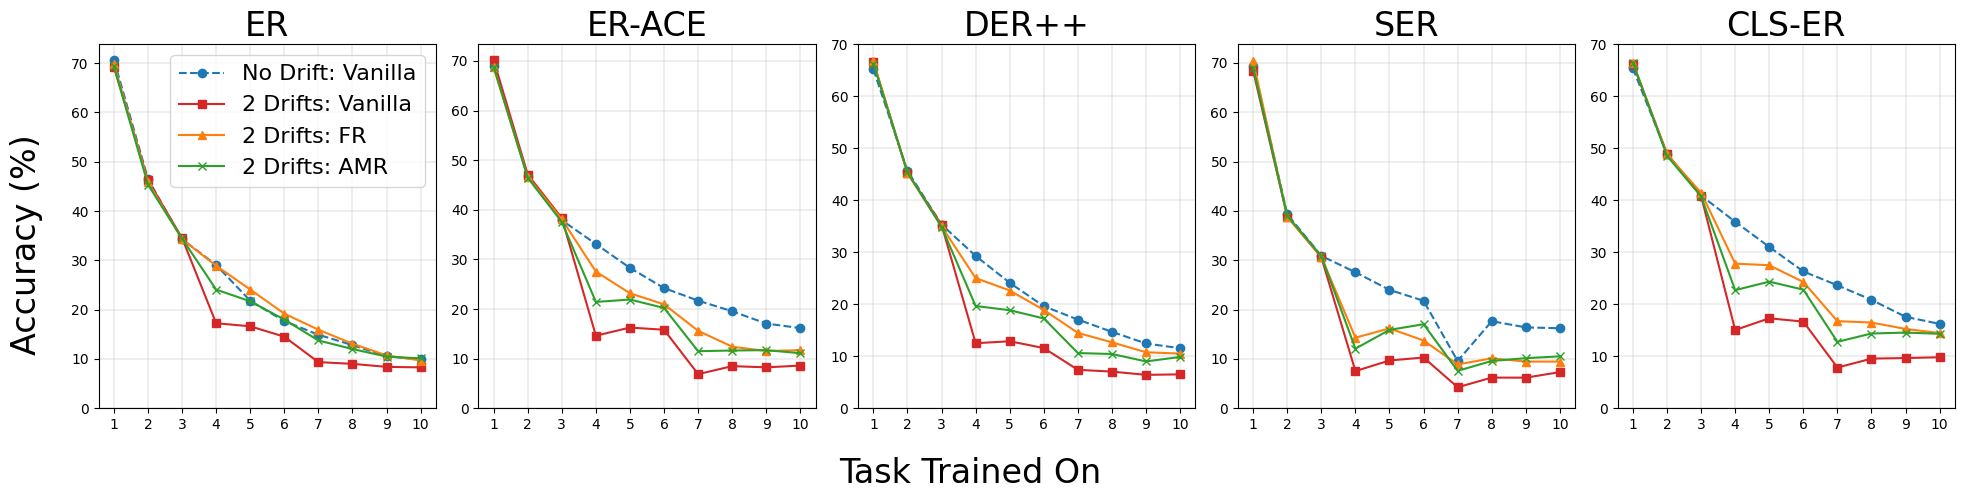

In [58]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: FR",
        "2 Drifts: AMR",
    ],
    plot_filename="TinyImg_Buff_5000_n_2.pdf",
)